In [1]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def set_values_for_hue(val):
    if val>55.0:
        return 2
    elif val<55.0 and val>40.0:
        return 1
    else :
        return 0

In [3]:
with open("C:\\Users\\pc\\Desktop\\flower_app\\flower_tensorflow\\result.json","rb") as f:
    json_to_dict=json.load(f)
df=pd.DataFrame(json_to_dict['final_result'])
df['accuracy']=df['accuracy']*100
print("before")
print(df.head())
print(df.columns)
df['level']=df['accuracy'].apply(lambda  x: set_values_for_hue(x))
print("after")
print(df.head())
print(df['level'].value_counts())

before
   round   accuracy
0      1  20.496000
1      2  36.568000
2      3  43.648000
3      4  50.848001
4      5  55.552000
Index(['round', 'accuracy'], dtype='object')
after
   round   accuracy  level
0      1  20.496000      0
1      2  36.568000      0
2      3  43.648000      1
3      4  50.848001      1
4      5  55.552000      2
level
2    100
1     12
0      8
Name: count, dtype: int64


<Axes: title={'center': 'Roundwise accuracy distribution'}, xlabel='round', ylabel='accuracy'>

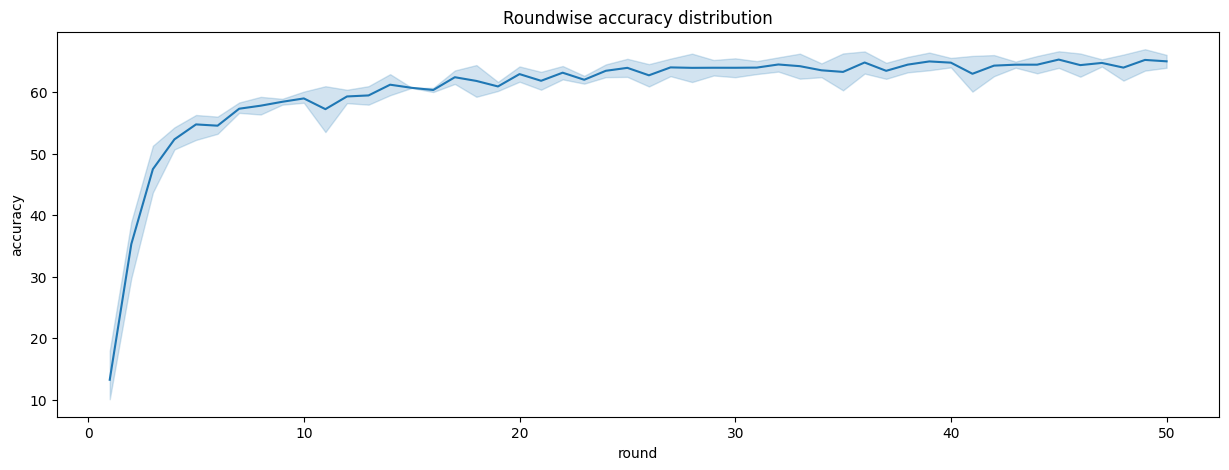

In [4]:
plt.figure(figsize=(15,5))
plt.title("Roundwise accuracy distribution",loc='center')
sns.lineplot(y=df['accuracy'],x=df['round'])

In [1]:
import tensorflow as tf
from tensorflow import keras
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from keras import layers
import numpy as np

In [24]:
partitioner = IidPartitioner(num_partitions=2) #num_partition specifies the number of client
fds = FederatedDataset(
            dataset="FastJobs/Visual_Emotional_Analysis",
            partitioners={"train": partitioner},
            trust_remote_code=True
            
        )
partition = fds.load_partition(0, "train") #partition_id specifies a unique id for selected client
partition.set_format("numpy")

c:\Users\pc\.conda\envs\py310\lib\site-packages\flwr_datasets\utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: FastJobs/Visual_Emotional_Analysis.
  warnings.warn(


Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

In [25]:
partition.shuffle(seed=10)

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [26]:
partition['label'][:10]

array([0, 7, 5, 4, 4, 7, 1, 0, 2, 3], dtype=int64)

In [6]:
partition.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

In [27]:
partition = partition.train_test_split(test_size=0.25)

In [28]:
partition["test"]['image'][0]

array([[[ 75,  76,  64],
        [ 76,  77,  65],
        [ 77,  78,  66],
        ...,
        [ 20,  22,  16],
        [ 20,  23,  17],
        [ 18,  21,  15]],

       [[ 75,  76,  64],
        [ 76,  77,  65],
        [ 76,  78,  66],
        ...,
        [ 22,  23,  18],
        [ 22,  24,  19],
        [ 22,  24,  18]],

       [[ 75,  76,  63],
        [ 76,  76,  65],
        [ 75,  77,  65],
        ...,
        [ 22,  27,  20],
        [ 23,  25,  20],
        [ 22,  26,  20]],

       ...,

       [[ 50,  46,  34],
        [141,  70,  34],
        [168,  58,  16],
        ...,
        [157,  91,  57],
        [208,  61,  18],
        [208,  61,  18]],

       [[124,  61,  24],
        [152,  56,  16],
        [175,  56,  14],
        ...,
        [212,  61,  23],
        [216,  57,  18],
        [194,  60,  21]],

       [[150,  57,  24],
        [155,  50,  13],
        [181,  53,  17],
        ...,
        [214,  58,  16],
        [190,  48,  16],
        [180,  35,   5]]

In [ ]:
type(partition['test']['image'])

numpy.ndarray

In [29]:
x_train, y_train = partition["train"]["image"]/255.0, partition["train"]["label"]
x_test, y_test = partition["test"]["image"]/255.0, partition["test"]["label"]

In [30]:
x_test.shape

(100, 96, 96, 3)

In [31]:
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

In [32]:
x_train.shape

(300, 96, 96, 3)

In [33]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(96,96,3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        #layers.Dense(256,activation='relu'),
        #layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(0.002) # Fixed: Removed extra indentation
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [34]:
model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.1670 - loss: 9.1804 - val_accuracy: 0.1400 - val_loss: 2.0833
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.2662 - loss: 6.8678 - val_accuracy: 0.1500 - val_loss: 2.0958
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.3298 - loss: 5.4212 - val_accuracy: 0.1300 - val_loss: 2.1111
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.5126 - loss: 3.4970 - val_accuracy: 0.0800 - val_loss: 2.1284
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.5308 - loss: 3.0022 - val_accuracy: 0.1500 - val_loss: 2.1023
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.6086 - loss: 2.4205 - val_accuracy: 0.1500 - val_loss: 2.6037
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.6048 - loss: 2.3738 - val_accuracy: 0.1500 - val_loss: 3.3157
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.7062 - loss: 1.7782 - val_accuracy: 0.